# Summary

In this notebook, I play with the pre-trained model: Faster RCNN. (Procedure is the same for Mask RCNN) we used Detectron2 lib, which is FAIR's next-generation platform for object detection and segmentation.

## Contents

1. load data and the pretrained model.
2. produce saliency maps:

*    Spatial attention map
*    Feature Map 
*    Objectness Logit map
*    CAM (not successful)

## References
1. detectron2: https://github.com/facebookresearch/detectron2
2. documentation: https://detectron2.readthedocs.io/tutorials/getting_started.html
2. rareplane dataset: https://github.com/aireveries/RarePlanes

# Install detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 'pycocotools>=2.0.1'
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

# Import Packages

In [ ]:
from detectron2.modeling import build_model

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model

In [ ]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import PIL
import requests
from torchvision.models._utils import IntermediateLayerGetter

In [ ]:
import json
import pandas as pd
import math
from tqdm import tqdm 
import cv2
import numpy as np
import os

import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import PIL
import requests
from PIL import Image
  
from sklearn import decomposition    
from sklearn.preprocessing import MinMaxScaler

# Load Data

These images should be wrongly predicted images.
Since I don't yet know how to get wrongly predicted images, I just used the predictions with less than 0.8 probabilities.

In [ ]:
def load_preds():
    '''
    load wrong predictions on real data
    '''
    coco_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/output/coco_instances_results.json"
    images_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/synthetic/test/images/"
    test_json_dir = coco_dir
    with open(test_json_dir) as json_file:
        preds_coco = json.load(json_file)
    preds_coco = pd.DataFrame(preds_coco)
    print("There are {} predicted bbox.".format(preds_coco.shape[0]))
    return preds_coco


def get_image_ann():
    '''
    load image annotations
    '''
    coco_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/aircraft_real_test_coco.json"
    images_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/test/RarePlanes_test_PS-RGB_tiled.tar.gz (Unzipped Files)/PS-RGB_tiled"
    test_json_dir = coco_dir
    with open(test_json_dir) as json_file:
        test_coco = json.load(json_file)
    img_list = pd.DataFrame(test_coco['images'])
    annotations = pd.DataFrame(test_coco['annotations'])
    ann = annotations.merge(img_list, how='left', left_on="image_id", right_on="id")
    return ann


def get_wrong_pred_img_id(threshold = 0.8):
    '''
    get hesitate predicted img ids
    '''
    img_ids = preds_coco[preds_coco["score"]<threshold].image_id.drop_duplicates().reset_index().image_id
    print("There are {} images with with a bit hesitation (prob<0.8). Let's study those images!".format(img_ids.shape[0]))
    return img_ids


def id2filename(img_ids, ann):
    # get img file dir
    return pd.DataFrame(img_ids, columns=["image_id"]).merge(ann[["image_id","file_name"]], 
                                                             how="left", on="image_id").drop_duplicates()


def load_wrong_images():
    images_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/test/RarePlanes_test_PS-RGB_tiled.tar.gz (Unzipped Files)/PS-RGB_tiled/"
    img_collections = []
    for f in tqdm(img_dirs.file_name):
        im = cv2.imread(images_dir+f)
        img_collections.append(im)
    img_collections = np.asarray(img_collections)  
    print("img_collections shape:",img_collections.shape)
    return img_collections

ann = get_image_ann()
preds_coco = load_preds()
img_ids = get_wrong_pred_img_id()
img_dirs = id2filename(img_ids, ann)
img_collections = load_wrong_images()

There are 6552 predicted bbox.
There are 43 images with with a bit hesitation (prob<0.8). Let's study those images!



img_collections shape: (43, 512, 512, 3)


In [ ]:
imagenet_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),])

# Load the pretrained model 

from RarePlane: https://github.com/aireveries/RarePlanes

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/111 Rendered.ai/rareplane_models/model_0043999.pth"
model = build_model(cfg)

In [ ]:
# print(model)

# 1. Spatial Attention Map/Feature Map

Attention paper: https://arxiv.org/abs/1612.03928 

In [ ]:
def attention_map(X, fast_rcnn, power=2):
    """
    Generate a localisation map for the predicted class given an input 
    image and a pretrained CNN
    
    Inputs:
    - X: Input image: synthetic data, Size of input torch.Size([1, 3, 512, 512])
    - fast_rcnn: Pretrained Fast RCNN on real data
    
    Returns:
    - localisation_maps : spatial attention map from FPN(feature pyramid network), p2-p6
    """
    fast_rcnn.eval()
    feature_map = fast_rcnn.backbone(X)
    localisation_maps = []
    for i in range(2,7):
        pi = feature_map["p"+str(i)]
        att_pi = pi.pow(power).mean(1)
        localisation_maps.append(att_pi)
    return np.asarray(localisation_maps)


def localisation(X, fast_rcnn):
    """
    Generate a localisation map for the predicted class given an input 
    image and a pretrained CNN
    
    Inputs:
    - X: Input image: synthetic data, Size of input torch.Size([1, 3, 512, 512])
    - fast_rcnn: Pretrained Fast RCNN on real data
    
    Returns:
    - localisation_map : feature map from FPN(feature pyramid network), p2-p6
    """
    fast_rcnn.eval()
    feature_map = fast_rcnn.backbone(X)
    localisation_maps = []
    for i in range(2,7):
        feature_map_pi = feature_map["p"+str(i)]
        map = feature_map_pi.mean(1)
        localisation_maps.append(map)
    return np.asarray(localisation_maps)


def objectness_logit_map(X, fast_rcnn):
    fast_rcnn.eval()
    feature_map = fast_rcnn.backbone(X)
    objectness_logit_maps = []
    for i in range(2,7):
        feature_map_pi = feature_map["p"+str(i)]
        out = fast_rcnn.proposal_generator.rpn_head.conv(feature_map_pi)
        # print(out.shape)
        out = fast_rcnn.proposal_generator.rpn_head.objectness_logits(out)
        # print(out.shape)
        sigmoid_fn = nn.Sigmoid()
        out = sigmoid_fn(out)
        map = out[0]
        objectness_logit_maps.append(map)
    return np.asarray(objectness_logit_maps)


def plotting(localization_maps, map_name):
    f, axarr = plt.subplots(1,5,figsize=(17,17))
    for i, map in enumerate(localization_maps):
        axarr[i].imshow(map[0].cpu().detach().numpy())
        axarr[i].set_title(str(map_name)+ " map of p"+str(i+2))


def upsampling(p_i, local_maps, upsampling_mode='nearest'):
    """
    Input:
    p_i: which pyramid in the FPN
    local_maps: a list of local_maps, which contains feature maps from p2 to p6.
    upsampling_mode: which upsampling method you choose from nn.upsample. default is 'nearest'.
    """
    p_i_to_scale_factor = {0:4, 1:8, 2:16, 3:32, 4:64}
    input = local_maps[p_i].view(1,local_maps[p_i].shape[0],local_maps[p_i].shape[1],-1)
    upsampler = nn.Upsample(scale_factor=p_i_to_scale_factor[p_i], mode='nearest')
    out = upsampler(input)
    return out


def overlay_heatmap(local_map, image, alpha=0.7, colormap=cv2.COLORMAP_JET):
    """
    Input:
    local_map: upsampled localization map size (512,512)
    image: orginial image (512, 512, 3) from cv2.imread()
    alpha: weights of activation map vs orginal image
    colormap: you choose whatever you like
    """
    # normalization
    heatmap = (local_map -local_map.min()) / (local_map.max()-local_map.min())
    # apply the supplied color map to the heatmap 
    CAM = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    # overlay the heatmap on the input image
    output = cv2.addWeighted(image, alpha, CAM, 1 - alpha, 0)
    # plot the output
    # f, axarr = plt.subplots(1,3,figsize=(15,15))
    # axarr[0].imshow(local_map)
    # axarr[0].set_title("local map")
    # axarr[1].imshow(heatmap)
    # axarr[1].set_title('Nomalized Heatmap')
    # axarr[2].imshow(output)
    # plt.title('Activation Map')
    return (heatmap, output)

Attention maps

In [ ]:
# send both the model to gpu
fast_rcnn = model.to(device)

n_imgs = img_collections.shape[0]
for i in tqdm(range(n_imgs)):
    im = img_collections[i]
    # send data to gpu
    X = imagenet_transform(im).unsqueeze(0).to(device)
    attention_maps = attention_map(X, fast_rcnn)
    for fpn_layer in range(5):
        att = upsampling(fpn_layer, attention_maps, upsampling_mode='nearest')
        att = att.cpu().detach().numpy()[0][0]
        (heatmap, output) = overlay_heatmap(att, im, alpha=0.75)
        # save as numpy arr
        output_name = "att_map_"+str(i)+"_fpn_layer="+str(fpn_layer+2)
        npy_dir = "/content/drive/MyDrive/111 Rendered.ai/output/attention_map/hesitate_predictions(<0.8)/images/"
        np.save(npy_dir+output_name, output)
        # save a jpg
        jpg_dir = "/content/drive/MyDrive/111 Rendered.ai/output/attention_map/hesitate_predictions(<0.8)/npy_arr/"
        Image.fromarray(output).save(jpg_dir+output_name+".jpeg")

Feature maps

In [ ]:
# send both the model to gpu
fast_rcnn = model.to(device)

n_imgs = img_collections.shape[0]
for i in tqdm(range(n_imgs)):
    im = img_collections[i]
    # send data to gpu
    X = imagenet_transform(im).unsqueeze(0).to(device)
    # plot feature maps
    feature_maps = localisation(X, fast_rcnn)
    for fpn_layer in range(5):
        map = upsampling(fpn_layer, feature_maps, upsampling_mode='nearest')
        map = map.cpu().detach().numpy()[0][0]
        (heatmap, output) = overlay_heatmap(map, im, alpha=0.75)
        # save as numpy arr
        output_name = "feature_map_"+str(i)+"_fpn_layer="+str(fpn_layer+2)
        npy_dir = "/content/drive/MyDrive/111 Rendered.ai/output/feature_map/hesitate_predictions(<0.8)/npy_arr/"
        np.save(npy_dir+output_name, output)
        # save a jpg
        jpg_dir = "/content/drive/MyDrive/111 Rendered.ai/output/feature_map/hesitate_predictions(<0.8)/images/"
        Image.fromarray(output).save(jpg_dir+output_name+".jpeg")

# 2. Objectness logits map

In [ ]:
# send both the model to gpu
fast_rcnn = model.to(device)

n_imgs = img_collections.shape[0]
for i in tqdm(range(n_imgs)):
    im = img_collections[i]
    # send data to gpu
    X = imagenet_transform(im).unsqueeze(0).to(device)
    # plot feature maps
    feature_maps = objectness_logit_map(X, fast_rcnn)
    for fpn_layer in range(5):
        map = upsampling(fpn_layer, feature_maps, upsampling_mode='nearest')
        map = map[0].permute(1,2,0).cpu().detach().numpy()
        (heatmap, output) = overlay_heatmap(map, im, alpha=0.75)
        # plt.imshow(output);plt.show()
        # save as numpy arr
        output_name = "objectness_logit_map_"+str(i)+"_fpn_layer="+str(fpn_layer+2)
        npy_dir = "/content/drive/MyDrive/111 Rendered.ai/output/objectiveness_logit_map/hesitate_predictions(<0.8)/npy_arr/"
        np.save(npy_dir+output_name, output)
        # save a jpg
        jpg_dir = "/content/drive/MyDrive/111 Rendered.ai/output/objectiveness_logit_map/hesitate_predictions(<0.8)/images/"
        Image.fromarray(output).save(jpg_dir+output_name+".jpeg")

In [ ]:
def plot_objectness_logit_map(X):
    fast_rcnn.eval()
    feature_map = fast_rcnn.backbone(X)
    f, axarr = plt.subplots(1,5, figsize=(15,15))
    for i in range(2,7):
        feature_map_pi = feature_map["p"+str(i)]
        # print(feature_map_pi.shape)
        out = fast_rcnn.proposal_generator.rpn_head.conv(feature_map_pi)
        # print(out.shape)
        out = fast_rcnn.proposal_generator.rpn_head.objectness_logits(out)
        # print(out.shape)
        sigmoid_fn = nn.Sigmoid()
        out = sigmoid_fn(out)
        out = out[0].permute(1,2,0)
        out_ = out.cpu().detach().numpy()
        # print(out_.shape)
        axarr[i-2].imshow(out_)
        axarr[i-2].set_title("objectness on p"+str(i))

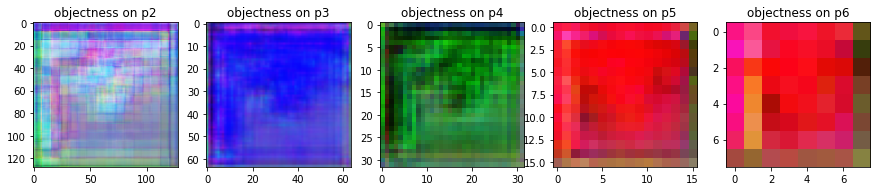

In [ ]:
plot_objectness_logit_map(X)

# 3. CAM

Disadvantage: only works for easy architectures, where there's Res + max_pooling + classification layer. But for FastRCNN, this is harder.

1. FPN: output size: (batch_size, 256, width, height)
2. Add a max pooling layer to replace the ROI network.
2. Classification layer: required input is (batch_size, 256, 7, 7) 

In [ ]:
fast_rcnn.eval()
feature_map = fast_rcnn.backbone(X)
feature_map.keys()

dict_keys(['p2', 'p3', 'p4', 'p5', 'p6'])

In [ ]:
feature_map["p2"].shape

torch.Size([1, 256, 128, 128])

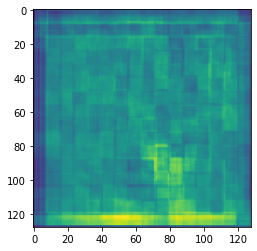

In [ ]:
plt.imshow(feature_map["p2"][0][1].cpu().detach().numpy())

In [ ]:
# get the feature map
feature_map_pi = feature_map["p5"]
print(feature_map_pi.shape)

# max pooling 
m = nn.MaxPool2d(3, stride=2)
out = m(feature_map_pi)
print(out.shape)

# classification layer
flater = fast_rcnn.roi_heads.box_head.flatten
out = flater(out)
print(out.shape)

fc_1 = fast_rcnn.roi_heads.box_head.fc1
out = fc_1(out)
out = fast_rcnn.roi_heads.box_head.fc_relu1(out)
print(out.shape)

cls = fast_rcnn.roi_heads.box_predictor.cls_score
out = cls(out)
print(out.shape)

torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 7, 7])
torch.Size([1, 12544])
torch.Size([1, 1024])
torch.Size([1, 81])


In [ ]:
softmax = nn.Softmax(dim=1)   # dim=3 represents the softmax is on the pixel. for each pixel, we take the softmax
logits = softmax(out)
print(logits.shape)

torch.Size([1, 81])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


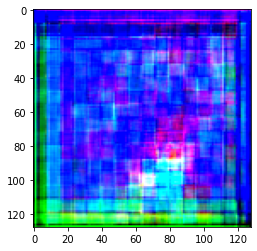

In [ ]:
out_ = out[0].permute(1,2,0)
plt.imshow(out_.cpu().detach().numpy())